# Protein Interaction in proteome

In this tutorial, we will analyze the changes in the protein interaction network under disease conditions in the proteome data with the help of BRICK, thereby analyzing the mechanism of disease occurrence. The data used in this tutorial is from **\<Integrated Proteomics Reveals Apoptosis-related
Mechanisms Associated with Placental Malaria\>**, which can be download at https://www.ebi.ac.uk/pride/archive/projects/PXD008079

## Loading Packages and Data

In [2]:
import BRICK
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

## Data Preprocess

Transfer the dataframe of proteome into an anndata object

In [58]:
df = pd.read_table('../KG_reg/Phosphopeptides_glycopeptides_evidence_TiO2_TMT_HUMAN.txt')

df = df[['Proteins', 'Gene names', 'Modifications',
 'Reporter intensity corrected 0',
 'Reporter intensity corrected 1',
 'Reporter intensity corrected 2',
 'Reporter intensity corrected 3',
 'Reporter intensity corrected 4',
 'Reporter intensity corrected 5',
 'Reporter intensity corrected 6',
 'Reporter intensity corrected 7',
 'Reporter intensity corrected 8',
 'Reporter intensity corrected 9']]

df = df.loc[df['Modifications'].isin(['Deamidation (NQ)', 'Phospho (STY)', 'Unmodified'])]

df.rename(columns={'Reporter intensity corrected 0': "Infected_1",
                    'Reporter intensity corrected 1': "Infected_2",
                    'Reporter intensity corrected 2': "Infected_3",
                    'Reporter intensity corrected 3': "Infected_4",
                    'Reporter intensity corrected 4': "Infected_5",
                    'Reporter intensity corrected 5': "Control_1",
                    'Reporter intensity corrected 6': "Control_2",
                    'Reporter intensity corrected 7': "Control_3",
                    'Reporter intensity corrected 8': "Control_4",
                    'Reporter intensity corrected 9': "Control_5"}, inplace=True)

X_col = ["Infected_1","Infected_2","Infected_3","Infected_4","Infected_5",
         "Control_1","Control_2","Control_3","Control_4","Control_5",]


df = df.loc[~df['Gene names'].isna()]
df = df.loc[(1-(df['Proteins'].str.contains(';'))).astype(bool)]
df['sum'] = df[X_col].sum(axis=1)
df = df.loc[ df['sum'] > 0 ]

df.set_index('Gene names', inplace=True)

adata = sc.AnnData(df[X_col].T, var=df[[x for x in df if x not in X_col]])

adata.obs['State'] = [x.split('_')[0] for x in adata.obs.index]
replace_dict = {'Deamidation (NQ)':'Gly', 'Phospho (STY)':'Pho', 'Unmodified':'Pro'}
adata.var['type'] = [replace_dict[x] for x in adata.var['Modifications']]

D:\Anaconda\envs\LLM\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [59]:
df

,Proteins,Modifications,Infected_1,Infected_2,Infected_3,Infected_4,Infected_5,Control_1,Control_2,Control_3,Control_4,Control_5,sum
Gene names,,,,,,,,,,,,,
ARID3A,Q99856,Phospho (STY),4167.70,4037.80,3831.20,2401.300,3882.30,2291.00,5461.20,5203.10,4473.70,4141.70,39891.000
SEPT11,Q9NVA2,Unmodified,1112.90,815.63,1151.70,13.243,747.66,923.80,607.32,1397.10,781.08,857.20,8407.633
SEPT11,Q9NVA2,Phospho (STY),7947.70,12522.00,9089.80,4326.800,5974.10,4907.80,4830.20,5909.20,8064.70,5063.80,68636.100
PCYT1A,P49585,Phospho (STY),2829.70,2788.10,2622.20,1973.600,1983.90,1897.90,2331.50,2762.70,2993.00,2276.80,24459.400
PURA,Q00577,Unmodified,153.08,245.29,673.57,0.000,153.64,589.79,250.41,623.44,245.50,273.58,3208.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LTBP1,Q14766,Deamidation (NQ),1000.20,888.87,764.82,720.900,1032.80,520.12,1283.30,1197.60,1078.30,1104.00,9590.910
DSG2,Q14126,Deamidation (NQ),8449.60,10112.00,12111.00,6526.900,8894.90,6879.50,7179.60,8501.60,8667.30,7624.10,84946.500
DSG2,Q14126,Deamidation (NQ),2989.80,3106.00,3265.70,2308.700,2717.90,2753.90,2957.70,2928.20,3321.20,2497.20,28846.300


## calculate differential expressed proteins

In [62]:
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby='State')
BRICK.pp.rank_genes_groups2df(adata)

Text(0, 0.5, '-Log(p-value)')

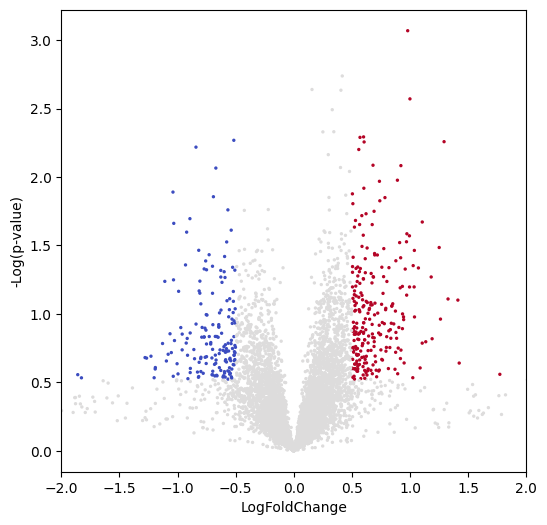

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6,6))

volcano_df = adata.uns['rank_genes_groups_df']['Infected']

volcano_df['x'] = volcano_df['logfoldchanges']
volcano_df['y'] = -1 * np.log10(volcano_df['pvals'])

p_value_cut_off = 0.3
y_cut_off = -1 * np.log10(p_value_cut_off)

volcano_df['type'] = 0
volcano_df.loc[(volcano_df['x'] < -0.5)&(volcano_df['y'] > y_cut_off), 'type'] = -1
volcano_df.loc[(volcano_df['x'] > 0.5)&(volcano_df['y'] > y_cut_off), 'type'] = 1

ax.scatter(volcano_df['x'], volcano_df['y'], s = 2, c = volcano_df['type'], cmap='coolwarm')

ax.set_xlim(-2,2)

ax.set_xlabel('LogFoldChange')
ax.set_ylabel('-Log(p-value)')

#fig.savefig('./volcano.pdf')

In [64]:
PRO_list = volcano_df.loc[volcano_df['type']!=0, ].index

len(PRO_list)

442

## query protein interaction

In [82]:
query_df = BRICK.qr.query_relation(PRO_list, source_entity_type='Protein', relation='activate')
query_df.drop_duplicates(['path.0.name', 'path.2.name'], inplace=True)
nxg = BRICK.pp.df2nxg(query_df)

### add color and shape for nodes to indicate logfoldchange and protein modification type

In [94]:
def value2color(value, cmap='bwr', vmax=1, vmin=-1):
    import matplotlib.pyplot as plt
    
    # 创建bwr调色板
    cmap = plt.get_cmap(cmap)
    
    # 计算每个值对应的颜色值
    color = cmap((value - vmin) / (vmax - vmin))
    r, g, b, a = color
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))
    return hex_color


def modification2shape(mod):
    #node2shape = {'G_':'square', 'P_':'triangle'}
    if mod == 'Deamidation (NQ)':
        return 'square'
    elif mod == 'Phospho (STY)':
        return 'triangle'
    else :
        return 'dot'

name2modification = dict(zip(adata.var_names, adata.var['Modifications']))
name2LogFC = dict(zip(volcano_df['names'], volcano_df['logfoldchanges']))

for n in nxg.nodes:
    nxg.nodes[n]['logFC'] = name2LogFC[n]
    nxg.nodes[n]['color'] = value2color(nxg.nodes[n]['logFC'])
    nxg.nodes[n]['modification'] = name2modification[n]
    nxg.nodes[n]['shape'] = modification2shape(nxg.nodes[n]['modification'])


for e in nxg.edges:
    x, y = e
    if nxg.nodes[x]['logFC'] * nxg.nodes[y]['logFC'] >= 0:
        nxg.edges[e]['color'] = 'red'
    else:
        nxg.edges[e]['color'] = 'blue'

In [97]:
for n in nxg.nodes:
    nxg.nodes[n]['name'] = n

In [98]:
nt = BRICK.pl.interact_visualize_network(nxg)
nt.show('ppi.html')

nx.html
ppi.html
